In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/Daily_electricity_consumption.csv')
df.head()

,date_time,active_power_consumed,meter_reading
0,01-01-2009,0.976869,1.946528
1,02-01-2009,1.616326,8.222917
2,03-01-2009,1.328817,7.249306
3,04-01-2009,1.347218,2.253472
4,05-01-2009,1.113889,6.006944


In [4]:
df.tail()

,date_time,active_power_consumed,meter_reading
690,22-11-2010,1.417733,7.038889
691,23-11-2010,1.095511,5.285417
692,24-11-2010,1.247394,8.488889
693,25-11-2010,0.993864,3.522222
694,26-11-2010,1.178230,7.908947


In [5]:
df.shape

(695, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_time              695 non-null    object 
 1   active_power_consumed  695 non-null    float64
 2   meter_reading          695 non-null    float64
dtypes: float64(2), object(1)
memory usage: 16.4+ KB


In [7]:
df.isnull().sum()

date_time                0
active_power_consumed    0
meter_reading            0
dtype: int64

In [8]:
time = pd.date_range(start='1/1/2009',end='11/26/2010',freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop('date_time',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [9]:
len(time)

695

In [10]:
df.head()

,active_power_consumed,meter_reading
time_stamp,,
2009-01-01,0.976869,1.946528
2009-01-02,1.616326,8.222917
2009-01-03,1.328817,7.249306
2009-01-04,1.347218,2.253472
2009-01-05,1.113889,6.006944


In [11]:
df.tail()

,active_power_consumed,meter_reading
time_stamp,,
2010-11-22,1.417733,7.038889
2010-11-23,1.095511,5.285417
2010-11-24,1.247394,8.488889
2010-11-25,0.993864,3.522222
2010-11-26,1.178230,7.908947


In [12]:
df = df[['active_power_consumed']]

In [13]:
df

,active_power_consumed
time_stamp,
2009-01-01,0.976869
2009-01-02,1.616326
2009-01-03,1.328817
2009-01-04,1.347218
2009-01-05,1.113889
...,...
2010-11-22,1.417733
2010-11-23,1.095511
2010-11-24,1.247394


In [14]:
plt.rcParams['figure.figsize'] = [15,8]

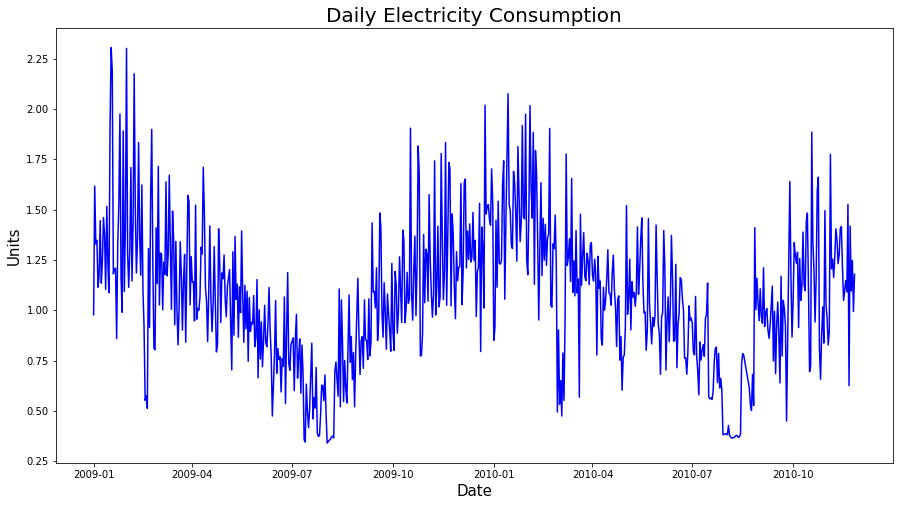

In [15]:
plt.plot(df,color='blue')
plt.title('Daily Electricity Consumption',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [16]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [76]:
#Split data set into testing dataset and train dataset
train_size = 618
train, test =df.values[0:train_size,:],df.values[train_size:len(df.values),:]
# setup look_back window 
look_back = 7
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [67]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(611, 7)
(611,)
(70, 7)
(70,)


In [19]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 14.2 MB/s 


In [20]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=256,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='elec_consum')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=33,
             validation_data=(testX, testY))

Trial 20 Complete [00h 01m 03s]
val_mape: 19.930190086364746

Best val_mape So Far: 18.36505889892578
Total elapsed time: 00h 13m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/elec_consum
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 1
units_0: 128
dropout: False
learning_rate: 0.001797384672015655
Score: 18.36505889892578
Trial summary
Hyperparameters:
num_layers: 8
units_0: 184
dropout: False
learning_rate: 0.0006105915571578281
units_1: 120
units_2: 168
units_3: 72
units_4: 72
units_5: 176
units_6: 32
Dropout_rate: 0.4
units_7: 176
units_8: 176
Score: 18.48346710205078
Trial summary
Hyperparameters:
num_layers: 8
units_0: 224
dropout: False
learning_rate: 0.0010990974938429258
units_1: 240
units_2: 16
units_3: 104
units_4: 176
units_5: 168
units_6: 80
Dropout_rate: 0.1
units_7: 144
units_8: 128
Score: 18.826292991638184
Trial summary
Hyperparameters:
num_layers: 3
units_0: 144
dropout: False
learning_rate: 0.00029202396584204445
units_1: 16
units_2: 128
units_3: 200
units_4: 48
units_5: 232
units_6: 40
Score: 19.01783847808838
Trial summary
Hyperparameters:


In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 10))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras import optimizers

In [83]:
model = Sequential()
model.add(Dense(16,activation='relu',input_dim = 7))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(2,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.0003007384672015655)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 33, epochs =400)

Epoch 1/400
19/19 [==============================] - 1s 9ms/step - loss: 98.3233 - mape: 98.3233 - val_loss: 96.4421 - val_mape: 96.4421
Epoch 2/400
19/19 [==============================] - 0s 2ms/step - loss: 93.7631 - mape: 93.7631 - val_loss: 90.7052 - val_mape: 90.7052
Epoch 3/400
19/19 [==============================] - 0s 2ms/step - loss: 84.5679 - mape: 84.5679 - val_loss: 76.4533 - val_mape: 76.4533
Epoch 4/400
19/19 [==============================] - 0s 2ms/step - loss: 59.3903 - mape: 59.3903 - val_loss: 45.1073 - val_mape: 45.1073
Epoch 5/400
19/19 [==============================] - 0s 2ms/step - loss: 32.5954 - mape: 32.5954 - val_loss: 26.1969 - val_mape: 26.1969
Epoch 6/400
19/19 [==============================] - 0s 2ms/step - loss: 24.0332 - mape: 24.0332 - val_loss: 22.6289 - val_mape: 22.6289
Epoch 7/400
19/19 [==============================] - 0s 3ms/step - loss: 22.9512 - mape: 22.9512 - val_loss: 22.6723 - val_mape: 22.6723
Epoch 8/400
19/19 [======================

In [84]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train MAPE : 16.951 
Test MAPE : 20.669 


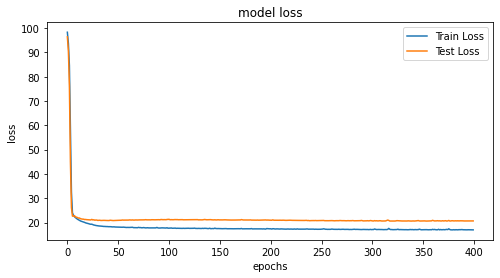

In [86]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

print('Train MAPE : %.3f ' % (train_score[1]))
print('Test MAPE : %.3f ' % (test_score[1]))
model_loss(model_history)

In [33]:
import seaborn as sns

In [88]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(611,681)]
    plt.figure(figsize=(15,8))
    plt.plot(trainY)
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

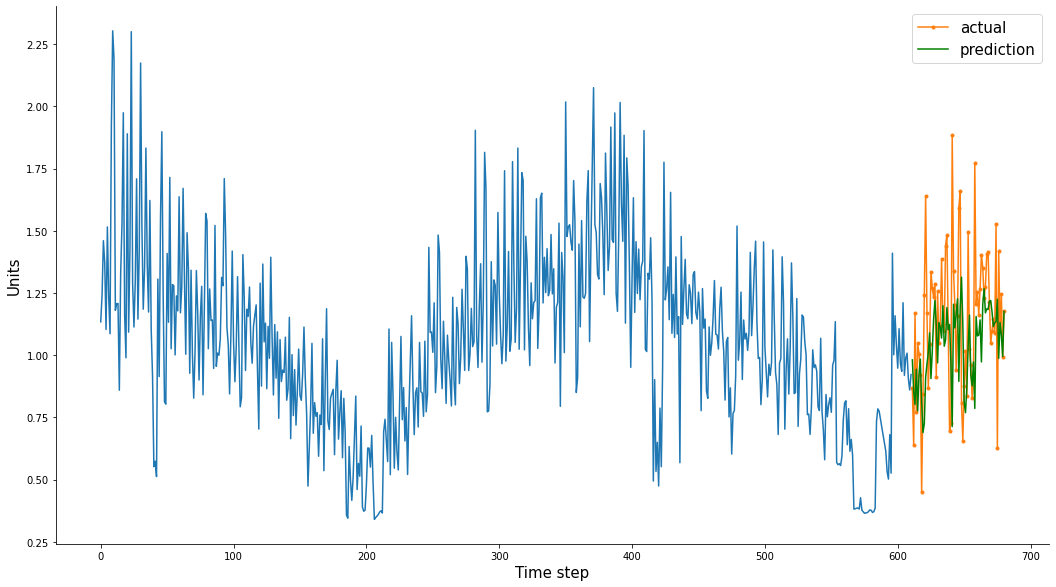

In [89]:
test_predict = model.predict(testX)
prediction_plot(testY, test_predict)